# Car Price Prediction

In [107]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

This project involves building a machine learning model to predict car prices using data gathered from Bulgarian car sales website. 
The project includes 
1. Data preprocessing.
2. Exploratory Data Analysis.
3. Feature Selection and Engineering.
4. Model training and Evaluation.

The goal is to create a reliable tool for estimating car prices.

### Load and Explore the Data

In [55]:
cars_data = pd.read_json('cars.json')

In [56]:
cars_data.head()

,Brand,Model,Price,Type,EngineType,TransmissionType,ManufactureDate,HorsePower,Color
0,audi,A4,26000.0,Комби,Дизел,Ръчна,2016-01-01T00:00:00,190,Сив
1,audi,A6,35000.0,Комби,Дизел,Автоматична,2013-01-01T00:00:00,313,Черен
2,audi,Q7,16000.0,Джип,Дизел,Автоматична,2010-01-01T00:00:00,280,Бежов
3,audi,Q7,13000.0,Джип,Дизел,Автоматична,2008-01-01T00:00:00,233,Черен
4,audi,A4,10000.0,Седан,Бензин,Ръчна,2001-01-01T00:00:00,220,Тъмно сив


In [57]:
cars_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39337 entries, 0 to 39336
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Brand             39337 non-null  object 
 1   Model             39337 non-null  object 
 2   Price             38994 non-null  float64
 3   Type              39337 non-null  object 
 4   EngineType        39337 non-null  object 
 5   TransmissionType  39337 non-null  object 
 6   ManufactureDate   39337 non-null  object 
 7   HorsePower        39337 non-null  int64  
 8   Color             39337 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 2.7+ MB


In [58]:
cars_data.shape

(39337, 9)

#### Rename the columns

First let's rename the columns to make the names more **Pythonic**.

In [59]:
cars_data.columns = ['brand', 'model', 'price', 'vehicle_type', 'engine_type', 'transmission_type', 'manufacture_date', 'horsepower', 'color']

In [60]:
cars_data.describe()

,price,horsepower
count,3.899400e+04,39337.000000
mean,2.172317e+04,153.059918
std,4.255122e+04,119.099573
min,1.100000e+01,0.000000
25%,5.700000e+03,95.000000
50%,1.030000e+04,131.000000
75%,2.099900e+04,177.000000
max,1.224200e+06,2400.000000


### Data Cleaning and Preparation

#### Get records whose Brand is empty and populate it

In [61]:
cars_data[cars_data['brand'].isna()]

,brand,model,price,vehicle_type,engine_type,transmission_type,manufacture_date,horsepower,color


In [62]:
def populate_missing_string_feature(df, missing_feature, match_feature):
    for index, row in df.iterrows():
        if(row[missing_feature] == ""):
            missing_feature_value = df.loc[df[match_feature] == row[match_feature]].iloc[0][missing_feature]
            df.at[index, missing_feature] = missing_feature_value

In [63]:
populate_missing_string_feature(cars_data, "brand", "model")

In [64]:
cars_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39337 entries, 0 to 39336
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              39337 non-null  object 
 1   model              39337 non-null  object 
 2   price              38994 non-null  float64
 3   vehicle_type       39337 non-null  object 
 4   engine_type        39337 non-null  object 
 5   transmission_type  39337 non-null  object 
 6   manufacture_date   39337 non-null  object 
 7   horsepower         39337 non-null  int64  
 8   color              39337 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 2.7+ MB


#### Drop the records where the target (Price) value is NaN is outlier.

In [65]:
cars_data = cars_data[cars_data['price'].isna() == False]

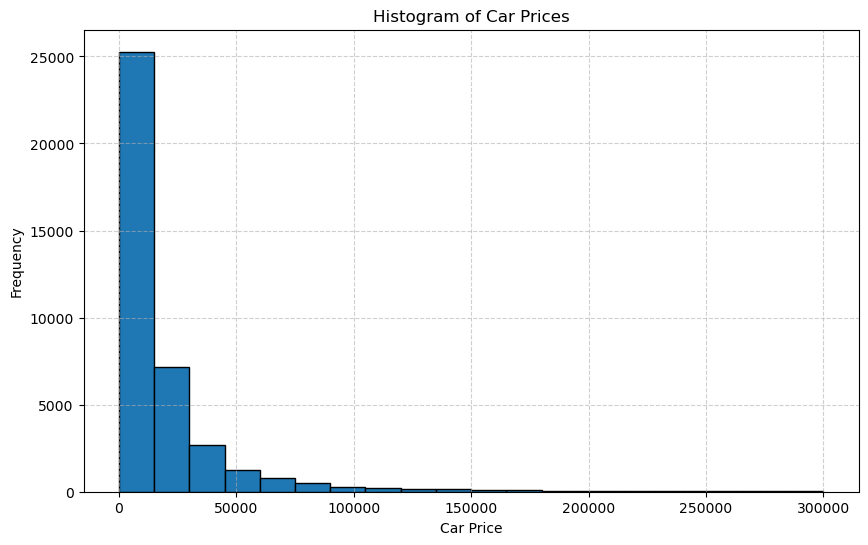

In [66]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

num_bins = 20
price_range = (0, 300000)  # Set the range of prices on the x-axis

plt.hist(cars_data['price'], bins=num_bins, range=price_range, edgecolor='black')

plt.xlabel('Car Price')
plt.ylabel('Frequency')
plt.title('Histogram of Car Prices')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

We see high frequency of cheap cars and a smaller frequency of pricier cars. Let's check for any otliers.

>Cars in price range [150000 - 250000]

In [67]:
cars_data[(cars_data['price'] > 150000) & (cars_data['price'] < 250000)]

,brand,model,price,vehicle_type,engine_type,transmission_type,manufacture_date,horsepower,color
211,audi,Rs5,184300.0,Седан,Бензин,Автоматична,2021-01-01T00:00:00,450,Сив
335,audi,Q8,159999.0,Джип,Бензин,Автоматична,2019-01-01T00:00:00,340,
365,audi,E-Tron,189980.0,Седан,Електрически,Автоматична,2021-01-01T00:00:00,476,Черен
377,audi,E-Tron,188980.0,Седан,Електрически,Автоматична,2021-01-01T00:00:00,476,Тъмно сив
394,audi,SQ7,179980.0,Джип,Дизел,Автоматична,2020-01-01T00:00:00,435,Тъмно сив
...,...,...,...,...,...,...,...,...,...
34607,tesla,Model X,229900.0,Джип,Електрически,Автоматична,2020-01-01T00:00:00,778,Бял
35871,toyota,Land cruiser,153000.0,Джип,Дизел,Автоматична,2022-01-01T00:00:00,204,Бял
36628,volvo,V90 Cross Country,150300.0,Комби,Дизел,Автоматична,2022-01-01T00:00:00,235,Графит
36653,volvo,Xc90,180600.0,Джип,Хибриден,Автоматична,2022-01-01T00:00:00,455,Графит


>Cars in price range [250000 - 350000]

In [68]:
cars_data[(cars_data['price'] > 250000) & (cars_data['price'] < 350000)]

,brand,model,price,vehicle_type,engine_type,transmission_type,manufacture_date,horsepower,color
28,audi,RSQ8,269990.0,Джип,Бензин,Автоматична,2020-01-01T00:00:00,600,Черен
401,audi,RSQ8,271980.0,Джип,Бензин,Автоматична,2021-01-01T00:00:00,600,Черен
415,audi,RSQ8,266980.0,Джип,Бензин,Автоматична,2021-01-01T00:00:00,600,Черен
430,audi,RSQ8,264980.0,Джип,Бензин,Автоматична,2021-01-01T00:00:00,600,Черен
895,audi,Rs6,280000.0,Комби,Бензин,Автоматична,2022-01-01T00:00:00,600,Tъмно син
...,...,...,...,...,...,...,...,...,...
30232,rolls-royce,Phantom,299999.0,Стреч лимузина,Бензин,Автоматична,2008-01-01T00:00:00,460,Сив
34496,tesla,Model X,258500.0,Джип,Електрически,Автоматична,2022-01-01T00:00:00,1020,Черен
34595,tesla,Model S,294000.0,Седан,Електрически,Автоматична,2022-01-01T00:00:00,1020,Черен
34596,tesla,Model S,294000.0,Седан,Електрически,Автоматична,2022-01-01T00:00:00,1020,Черен


>Cars in price range [350000 - 450000]

In [69]:
cars_data[(cars_data['price'] > 250000) & (cars_data['price'] < 350000)]

,brand,model,price,vehicle_type,engine_type,transmission_type,manufacture_date,horsepower,color
28,audi,RSQ8,269990.0,Джип,Бензин,Автоматична,2020-01-01T00:00:00,600,Черен
401,audi,RSQ8,271980.0,Джип,Бензин,Автоматична,2021-01-01T00:00:00,600,Черен
415,audi,RSQ8,266980.0,Джип,Бензин,Автоматична,2021-01-01T00:00:00,600,Черен
430,audi,RSQ8,264980.0,Джип,Бензин,Автоматична,2021-01-01T00:00:00,600,Черен
895,audi,Rs6,280000.0,Комби,Бензин,Автоматична,2022-01-01T00:00:00,600,Tъмно син
...,...,...,...,...,...,...,...,...,...
30232,rolls-royce,Phantom,299999.0,Стреч лимузина,Бензин,Автоматична,2008-01-01T00:00:00,460,Сив
34496,tesla,Model X,258500.0,Джип,Електрически,Автоматична,2022-01-01T00:00:00,1020,Черен
34595,tesla,Model S,294000.0,Седан,Електрически,Автоматична,2022-01-01T00:00:00,1020,Черен
34596,tesla,Model S,294000.0,Седан,Електрически,Автоматична,2022-01-01T00:00:00,1020,Черен


>Cars with Price > 450000

In [70]:
cars_data[(cars_data['price'] > 450000)]

,brand,model,price,vehicle_type,engine_type,transmission_type,manufacture_date,horsepower,color
25,audi,A8,620000.0,Стреч лимузина,Дизел,Автоматична,2015-01-01T00:00:00,385,Черен
4297,aston-martin,martin DBS,475000.0,Купе,Бензин,Автоматична,2021-01-01T00:00:00,725,Светло сив
4303,aston-martin,martin DBS,639800.0,Купе,Бензин,Автоматична,2022-01-01T00:00:00,725,Черен
4308,aston-martin,martin .,453600.0,Кабрио,Бензин,Автоматична,2022-01-01T00:00:00,510,Зелен
4321,bentley,Bentayga,512000.0,Джип,Бензин,Автоматична,2020-01-01T00:00:00,550,Черен
...,...,...,...,...,...,...,...,...,...
30226,rolls-royce,Ghost,548000.0,Седан,Бензин,Автоматична,2022-01-01T00:00:00,571,Черен
30227,rolls-royce,Ghost,699000.0,Седан,Бензин,Автоматична,2021-01-01T00:00:00,571,Син
30234,rolls-royce,Cullinan,608980.0,Джип,Бензин,Автоматична,2022-01-01T00:00:00,600,Черен
30235,rolls-royce,Cullinan,587980.0,Джип,Бензин,Автоматична,2022-01-01T00:00:00,600,Черен


Even though there are some exceptionally high-priced cars everything with the data seems OK as these cars are with kind of special characteristics. Now let's check if we have some exceptionally cheap cars.

>Cars with Price < 300

In [71]:
cars_data[(cars_data['price'] < 300)]

,brand,model,price,vehicle_type,engine_type,transmission_type,manufacture_date,horsepower,color
529,audi,A5,11.0,Купе,Дизел,Автоматична,2010-01-01T00:00:00,239,Тъмно син мет.
1151,audi,A8,11.0,Седан,Дизел,Автоматична,2001-01-01T00:00:00,180,Тъмно син мет.
2586,bmw,X3,11.0,Джип,Дизел,Автоматична,2007-01-01T00:00:00,177,Зелен
2589,bmw,525,11.0,Седан,Дизел,Автоматична,2008-01-01T00:00:00,197,
2656,bmw,320,11.0,Седан,Дизел,Автоматична,2018-01-01T00:00:00,190,Черен
...,...,...,...,...,...,...,...,...,...
38249,vw,Polo,11.0,Хечбек,Бензин,Ръчна,2005-01-01T00:00:00,75,Tъмно син
38825,vw,Passat,123.0,Комби,Бензин,Автоматична,1999-01-01T00:00:00,193,
38852,vw,Passat,11.0,Комби,Дизел,Автоматична,2008-01-01T00:00:00,140,
38982,vw,Passat,111.0,Комби,Бензин,Ръчна,1995-01-01T00:00:00,101,


It seems like we have a bunch of exceptionally cheap cars which are most likely ads for selling car parts or broken cars so we will drop them as we do not need those records. 

In [72]:
cars_data = cars_data.drop(cars_data[cars_data['price'] < 300].index)

#### Cars with too much horse power

In [73]:
cars_data[cars_data['horsepower'] > 800]

,brand,model,price,vehicle_type,engine_type,transmission_type,manufacture_date,horsepower,color
1159,audi,A3,6600.0,Хечбек,Дизел,Ръчна,2005-01-01T00:00:00,2000,Черен
1350,audi,S8,97700.0,Седан,Бензин,Автоматична,2012-01-01T00:00:00,1000,Сив
1354,audi,S8,72999.0,Стреч лимузина,Бензин,Автоматична,2013-01-01T00:00:00,900,Бял
1547,audi,A3,29000.0,Седан,Дизел,Автоматична,2016-01-01T00:00:00,1600,Черен
3386,bmw,X3,14800.0,Джип,Дизел,Автоматична,2009-01-01T00:00:00,1177,Светло сив
...,...,...,...,...,...,...,...,...,...
38338,vw,Passat,13500.0,Комби,Дизел,Ръчна,2012-01-01T00:00:00,1598,Черен
38569,vw,Golf,6300.0,Седан,Бензин,Ръчна,2004-01-01T00:00:00,1200,Сив
38658,vw,Touran,9000.0,Миниван,Бензин,Ръчна,2006-01-01T00:00:00,1400,Сив
38978,vw,Golf,2500.0,Хечбек,Бензин,Ръчна,1999-01-01T00:00:00,1595,Зелен


It appears that some car ads feature exceptionally high horsepower values. Removing these outliers is advisable since they seem unrealistic and are likely to have a negative impact on the model's accuracy and reliability. However, since there are many cars with high horsepower, we will only remove those with a price below $30,000. Additionally, there appear to be outliers with unusually low prices but high horsepower, which we will also exclude.

In [74]:
cars_data = cars_data.drop(cars_data[(cars_data['horsepower'] > 500) & (cars_data['price'] < 30000)].index)
cars_data = cars_data.drop(cars_data[cars_data['horsepower'] > 1000].index)

#### Cars with low Horsepower

In [75]:
cars_data[(cars_data['horsepower'] == 0)]

,brand,model,price,vehicle_type,engine_type,transmission_type,manufacture_date,horsepower,color
79,audi,80,2800.0,Седан,Бензин,Ръчна,1991-01-01T00:00:00,0,Бял
93,audi,A4,7500.0,Комби,Дизел,Автоматична,2008-01-01T00:00:00,0,Светло сив
101,audi,A1,6000.0,Хечбек,Бензин,Ръчна,2011-01-01T00:00:00,0,Черен
138,audi,Q3,72000.0,Джип,Бензин,Автоматична,2020-01-01T00:00:00,0,Бял
246,audi,A6,10800.0,Седан,Дизел,Автоматична,2008-01-01T00:00:00,0,Tъмно син
...,...,...,...,...,...,...,...,...,...
39226,vw,Touran,4990.0,Хечбек,Дизел,Ръчна,2006-01-01T00:00:00,0,Тъмно син мет.
39253,vw,Passat,3400.0,Седан,Дизел,Ръчна,2000-01-01T00:00:00,0,Tъмно син
39297,vw,Caddy,7500.0,Пикап,Дизел,Ръчна,2009-01-01T00:00:00,0,Бял
39310,vw,Golf,10500.0,Хечбек,Дизел,Ръчна,2009-01-01T00:00:00,0,Черен


It seems like there a lot of rows ads with no horse power. We will use a fucntion to populate the feature using similar techinque as when we populated the missing brands. 

First we will need to convert the manufacture_date column to date type. 

In [76]:
cars_data['manufacture_date'] = pd.to_datetime(cars_data['manufacture_date'])

In [83]:
def fill_missing_horsepower(df, price_diff = 1000, days_diff = 900):
    # Iterate over rows with missing horsepower
    for index, row in df[df['horsepower'] == 0].iterrows():
        criteria = (
            (df['brand'] == row['brand']) &
            (df['model'] == row['model']) &
            (df['price'] >= row['price'] - price_diff) &  # Adjust similarity threshold as needed
            (df['price'] <= row['price'] + price_diff) &
            (abs(df['manufacture_date'] - row['manufacture_date']).dt.days <= days_diff)  # Adjust similarity threshold as needed
        )
        similar_records = df[criteria]
        mean_horsepower = similar_records['horsepower'].mean()
        df.at[index, 'horsepower'] = mean_horsepower
    

In [81]:
fill_missing_horsepower(cars_data)

In [82]:
cars_data[(cars_data['horsepower'] == 0)]

,brand,model,price,vehicle_type,engine_type,transmission_type,manufacture_date,horsepower,color
101,audi,A1,6000.0,Хечбек,Бензин,Ръчна,2011-01-01,0.0,Черен
138,audi,Q3,72000.0,Джип,Бензин,Автоматична,2020-01-01,0.0,Бял
522,audi,A8,2200.0,Седан,Дизел,Автоматична,2002-01-01,0.0,Тъмно син мет.
657,audi,A1,25999.0,Хечбек,Дизел,Ръчна,2017-01-01,0.0,Черен
900,audi,SQ7,116000.0,Джип,Дизел,Автоматична,2017-01-01,0.0,Бял
...,...,...,...,...,...,...,...,...,...
38051,vw,Multivan,35000.0,Миниван,Дизел,Ръчна,2008-01-01,0.0,Черен
38173,vw,Caddy,17200.0,Пикап,Дизел,Ръчна,2016-01-01,0.0,Бял
38174,vw,Amarok,25700.0,Пикап,Дизел,Ръчна,2011-01-01,0.0,Бял
38579,vw,Up,8200.0,Хечбек,Бензин,Ръчна,2012-01-01,0.0,Черен


Now that we have fewer records with no horsepower, I will use a larger price range and a greater number of days' difference to populate those.

In [84]:
fill_missing_horsepower(cars_data, 3000)

In [85]:
fill_missing_horsepower(cars_data, 10000)

In [86]:
fill_missing_horsepower(cars_data, 10000, 3000)

In [87]:
cars_data[(cars_data['horsepower'] == 0)]

,brand,model,price,vehicle_type,engine_type,transmission_type,manufacture_date,horsepower,color
3911,alfa-romeo,Romeo Gtv,18000.0,Купе,Бензин,Ръчна,1969-01-01,0.0,Син
3912,alfa-romeo,Romeo Giulietta,5000.0,Седан,Бензин,Ръчна,1958-01-01,0.0,
4316,austin,Mini,5500.0,Седан,Бензин,Ръчна,1977-01-01,0.0,Оранжев
4392,buick,Skylark,19999.0,Седан,Бензин,Автоматична,1988-01-01,0.0,Бял
4558,chevrolet,Camaro,51000.0,Купе,Бензин,Автоматична,1970-01-01,0.0,Зелен
...,...,...,...,...,...,...,...,...,...
34190,subaru,E12,1499.0,Ван,Бензин,Ръчна,1996-01-01,0.0,Сив
34832,toyota,Mr2,6666.0,Кабрио,Бензин,Ръчна,2000-01-01,0.0,Графит
36522,uaz,2206,6000.0,Джип,Дизел,Ръчна,1982-01-01,0.0,
36532,uaz,69,2500.0,Джип,Бензин,Ръчна,1977-01-01,0.0,Зелен


Leaving these 74 records with missing horsepower values is justifiable, especially since these entries seem to represent a collection of unique or rare car models that hold particular interest or significance. Since the absence of horsepower data does not substantially impact the primary objectives of our analysis or modeling, preserving these distinct records will allow us to maintain a comprehensive and representative dataset.

#### Remove duplicates

In [88]:
cars_data = cars_data.drop_duplicates()

### Data Exploration

Scatter plot for two numerical columns, e.g., 'HorsePower' vs. 'Price'

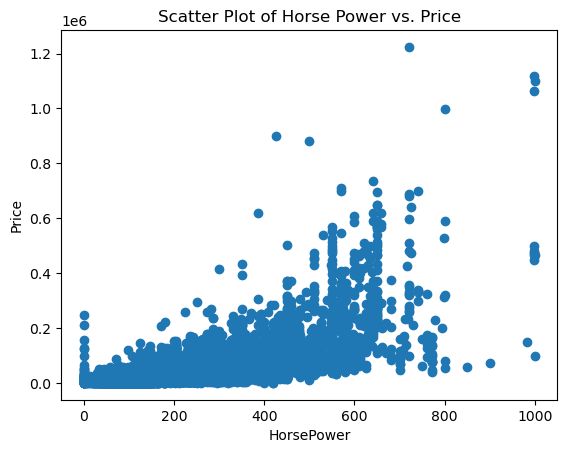

In [89]:
plt.scatter(cars_data['horsepower'], cars_data['price'])
plt.xlabel('HorsePower')
plt.ylabel('Price')
plt.title('Scatter Plot of Horse Power vs. Price')
plt.show()

Lets zoom the scatter to explore the data better

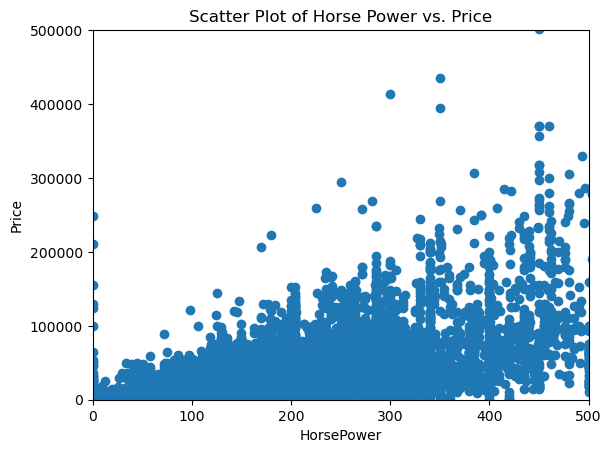

In [90]:
plt.scatter(cars_data['horsepower'], cars_data['price'])
plt.xlabel('HorsePower')
plt.ylabel('Price')
plt.title('Scatter Plot of Horse Power vs. Price')

plt.xlim(0, 500)
plt.ylim(0, 500000)

plt.show()

In [91]:
correlation_coefficient = cars_data['horsepower'].corr(cars_data['price'])
print("Horse Power - Price Correlation Coefficient:", correlation_coefficient)

Horse Power - Price Correlation Coefficient: 0.6774561657841507


Now lets see the correlation between the manufacture date and price. 

In [92]:
current_date = datetime.datetime(2023, 9, 24) # Current date.
cars_data['car_age'] = (current_date - cars_data['manufacture_date']).dt.days // 365  # Calculate age in years

# Drop the original 'ManufactureDate' column if it's no longer needed
cars_data = cars_data.drop(columns=['manufacture_date'])

correlation_coefficient = cars_data['car_age'].corr(cars_data['price'])
print("Car Age - Price Correlation Coefficient:", correlation_coefficient)

Car Age - Price Correlation Coefficient: -0.4226140040319893


There is a moderately strong positive correlation of 0.67 between the horsepower of cars and their prices, suggesting that, on average, cars with higher horsepower tend to be priced higher, while cars with lower horsepower tend to be priced lower.

On the other hand the negative sign (-0.423 Car Age - Price correlation) confirms that as car age increases, car price tends to decrease. This is a logical finding because older cars typically have lower market values compared to newer ones.

### Feature Engineering

#### Convert categorical variables to numerical.

We will use the `One-Hot Encoding` approach instead of the `Label Encoding` as the second approach is more suitable in scenarios where we have ordinal categorical variables like `low`-`medium`-`high`.

In [93]:
cars_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38176 entries, 0 to 39335
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              38176 non-null  object 
 1   model              38176 non-null  object 
 2   price              38176 non-null  float64
 3   vehicle_type       38176 non-null  object 
 4   engine_type        38176 non-null  object 
 5   transmission_type  38176 non-null  object 
 6   horsepower         38176 non-null  float64
 7   color              38176 non-null  object 
 8   car_age            38176 non-null  int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 2.9+ MB


In [94]:
cars_data = pd.get_dummies(cars_data, columns=['brand', 'model', 'vehicle_type', 'engine_type', 'transmission_type'])

In [95]:
cars_data.shape

(38176, 1311)

#### Remove columns

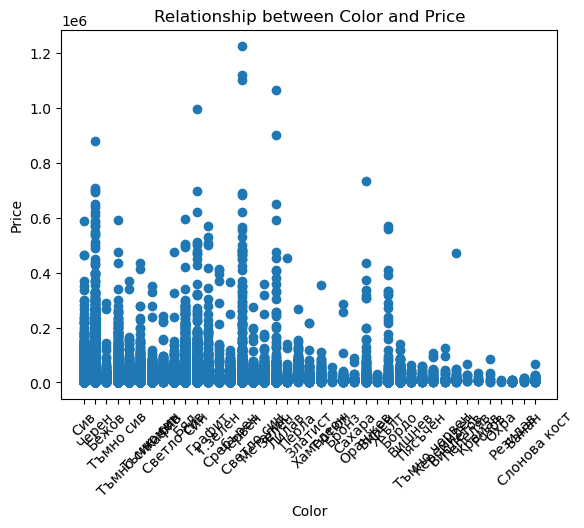

In [104]:
plt.scatter(cars_data['color'], cars_data['price'])
plt.xlabel('Color')
plt.ylabel('Price')
plt.title('Relationship between Color and Price')
plt.xticks(rotation=45)
plt.show()

It appears that there is no significant relationship between color and price, so we can drop this column.

In [105]:
cars_data = cars_data.drop('color', axis=1)

In [106]:
cars_data.shape

(38176, 1310)

#### Feature Scaling

In [ ]:
scaler = StandardScaler()
df['scaled_feature'] = scaler.fit_transform(df[['original_feature']])